# Исследование рынка видеоигр

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Необходимо выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Подготовка данных 

Испортируем библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats as st
import seaborn as sns

Прочитаем данные с файла и сохраним в data.

In [2]:
data = pd.read_csv('/datasets/games.csv')

Просмотрим общую информацию о данных.

In [3]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Согласно документации к данным, в таблице `games` имеются следующие столбцы:
* `Name` — название игры
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Посмотрев на общую информацию о данных, можно уже заметить некотрые ошибки и неудобства в типах даннных (*User_Score* имеет тип object, *Year_of_Release* тип float64) и что слолбцы не соответствуют snake case. Сразу уже можно заметить наличие пропущенных значений в некоторых слобцах.

**Подготовим данные для дальнейшей работы.**

#### Исправим названия столбцов.

In [4]:
data.columns = data.columns.str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Обработаем пропущенные значения в столбцах.

In [5]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Пропущеные значения есть в столбцах *name*, *genre*, *year_of_release*, *critic_score*, *user_score*, *rating*.

Рассмотрим строки с отсутсвующим названием.

In [6]:
 data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Видим интересный факт, строки с отсутсвием названия и отсутвием жанра - это одни и те же строки.

Посмотрим на значения *user_score*

In [7]:
(data[data['user_score'].notna()]['user_score'].sort_values(ascending = False).unique())

array(['tbd', '9.7', '9.6', '9.5', '9.4', '9.3', '9.2', '9.1', '9', '8.9',
       '8.8', '8.7', '8.6', '8.5', '8.4', '8.3', '8.2', '8.1', '8', '7.9',
       '7.8', '7.7', '7.6', '7.5', '7.4', '7.3', '7.2', '7.1', '7', '6.9',
       '6.8', '6.7', '6.6', '6.5', '6.4', '6.3', '6.2', '6.1', '6', '5.9',
       '5.8', '5.7', '5.6', '5.5', '5.4', '5.3', '5.2', '5.1', '5', '4.9',
       '4.8', '4.7', '4.6', '4.5', '4.4', '4.3', '4.2', '4.1', '4', '3.9',
       '3.8', '3.7', '3.6', '3.5', '3.4', '3.3', '3.2', '3.1', '3', '2.9',
       '2.8', '2.7', '2.6', '2.5', '2.4', '2.3', '2.2', '2.1', '2', '1.9',
       '1.8', '1.7', '1.6', '1.5', '1.4', '1.3', '1.2', '1.1', '1', '0.9',
       '0.7', '0.6', '0.5', '0.3', '0.2', '0'], dtype=object)

Видим, что имеется аббревиатура "tbd", которая рассшифровывается как"to be defined", что значит "предстоит определить". У такой игры еще нет рейтинга, заменить его на 0 нельзя, так как отсутвие рейтинга =! нулевому ретингу (игры могут смешаться с играми с действительно незкой популярностью), поэтому заменим *tbd* на *Nan*

In [8]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = float('nan')

Посмотрим на значения *rating*

In [9]:
(data[data['rating'].notna()]['rating'].sort_values(ascending = False).unique())

array(['T', 'RP', 'M', 'K-A', 'EC', 'E10+', 'E', 'AO'], dtype=object)

Видно устаревший рейтинг *K-A* (*Kids to Adults*), который сейчас обозначается как *E* (*Everyone*).

In [10]:
data['rating'] = data['rating'].replace('K-A', 'E')

Еще раз взглянем на пропуски

In [11]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Итак:
1. Изучать игры без названия бессмысленно, они могу портить данные. Удалим их.
2. Пропусков годах выпуска всего 269 штук из 16715, возможно они появились при переносе данных. Заполнить эти пропуски мы никак не можем, поэтому удалим строки с пропущенным годом.
3. Имеющиеся в данных пропуски рейтинга лучше заполнить значением *RP* (*Rating Pending* - рейтинг ожидается). Такие значения ставятся у игр, которые были отправлены в ESRB и ожидает присвоения рейтинга. Конечно не факт, что все игры с пропусками были отправлены на проверку, но фактически и те и другие игры рейтинга не имеют.
4. Пропуски в столбцах рейтингов критиков и пользователей оставим без изменений. Не каждая игра могла дойти до оценки критиков или отдельых регионов, заполнить такие данные нечем, но и удалять их тоже нельзя.

In [12]:
data = data.dropna(subset=['name']).reset_index(drop = True)
data = data.dropna(subset=['year_of_release']).reset_index(drop = True)
data['rating'] = data['rating'].fillna(value =' RP')
# проверка изменения данных
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
dtype: int64

#### Обработка типов данных

Преобразуем типы года выпуска и оценки пользователей

In [13]:
data['year_of_release'] = data['year_of_release'].astype(int)
data['user_score'] = data['user_score'].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


#### Обработка дубликатов

Проверим наличие явных дубликатов.

In [14]:
data.duplicated().sum()

0

Явных дубликатов нет.

В таблице `games` есть строковые столбцы *name*, *platform*, *genre*. Проверим их на наличие неявных дубликатов.

In [15]:
# выведем список уникальных значений name
data['name'].sort_values().unique()

array([' Beyblade Burst', ' Fire Emblem Fates', " Frozen: Olaf's Quest",
       ..., 'uDraw Studio', 'uDraw Studio: Instant Artist',
       '¡Shin Chan Flipa en colores!'], dtype=object)

Неявных дубликатов в названиях нет.

In [16]:
# выведем список уникальных значений platform
data['platform'].sort_values().unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

Неявных дубликатов в платвормах нет.

In [17]:
# выведем список уникальных значений genre
data['genre'].sort_values().unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

Неявных дубликатов в платвормах нет.

#### Посчитаем суммарные продажи во всех регионах

In [18]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,RP,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,RP,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,RP,28.31


**Вывод этапа**:
- Проведена проверка данных на начличие пропущенных значений. Пропуски были обнаружены в столбцах `name` (такие строки удалены), `genre` (такие строки удалены), `year_of_release` (такие строки удалены), `rating` (пропуски заменены на значение *RP*), `critic_score` (оставлено без изменений),	`user_score`(оставлено без изменений).
- Приведены имена столбцов к snake_case.
- Были проверены неявные и явные дубликаты. Таких обнаружено не было.
- Столбец с годом выпуска приведен к типу *int*, `user_score` к типу *float*
- Добавлен новый столбец с сумарной продажей во всех регионах `total_sales`

### Исследовательский анализ данных

#### Посмотрим, сколько игр выпускалось в разные годы

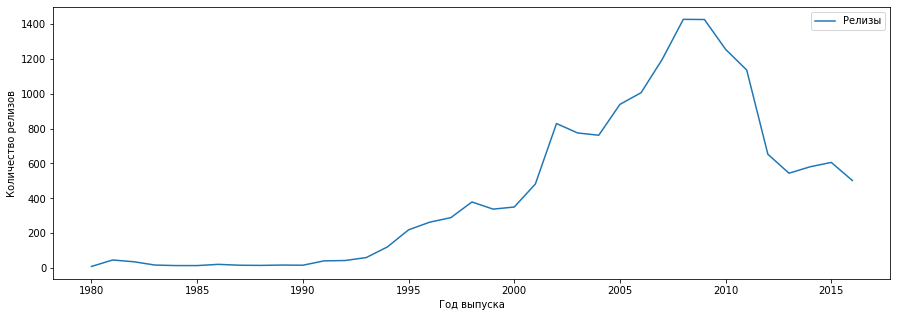

In [19]:
plt.figure(figsize=(15,5))
plt.plot(data.groupby('year_of_release')['name'].count(), label='Релизы')
plt.legend()
plt.xlabel('Год выпуска')
plt.ylabel('Количество релизов')
plt.show()

In [20]:
print(data.groupby('year_of_release')['name'].count().sort_values(ascending=False).head(10))
data.groupby('year_of_release')['name'].count().sort_values(ascending=False).tail(10)

year_of_release
2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
Name: name, dtype: int64


year_of_release
1982    36
1986    21
1989    17
1983    17
1990    16
1987    16
1988    15
1985    14
1984    14
1980     9
Name: name, dtype: int64

По графику можем заметить, что начало расцвета игровой индустрии можно отнести к примерно 1993 году, да этого момента количество выпущенных игр не превышало 100 в год, поэтому эти данные нельзя назвать актуальными.

Взлет популярности видеоигр можно отнести как развитию и повышению доступности технологий, потому что именно в 90х годах начали повсеместно появляться домашние ПК, и начала расширяться-развиваться индустрия консолей.

#### Посмотрим, как менялись продажи по платформам

Для начала категоризуем различные платформы по видам и производителям.

In [21]:
# типы платформ
def platform_type(platform):
    portable = ['GB', 'DS', 'GBA', '3DS', 'PSP', 'PSV', 'GG']
    stationary = ['Wii', 'NES', 'X360', 'PS3', 'PS2', 'SNES', 'PS4', 'N64', 'PS', 'XB', '2600', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'SAT', 'SCD', 'WS', 'NG', 'TG16','3DO', 'PCFX']
    if platform in portable:
        platform_type = 'portable'
    if platform in stationary:
        platform_type = 'stationary' 
    if platform == 'PC':
        platform_type = 'PC'
    return platform_type


# производители консолей
def company_name(platform):
    companies = {'Atary' : ['2600'], 
                'Bandai' : ['WS'],
                'Microsoft' : ['X360', 'XOne', 'XB'],
                'NEC' : ['TG16', 'PCFX'],
                'Nintendo' : ['N64', '3DS', 'Wii', 'WiiU', 'NES', 'SNES', 'GB', 'GC', 'DS', 'GBA'],
                'Sega' : ['GG', 'GEN', 'SAT', 'DC', 'SCD'],
                'Sony' : ['PS', 'PS2', 'PS3', 'PS4', 'PSV', 'PSP'],
                'Panasonic' : ['3DO'],
                'SNK' : ['NG'],
                'PC' : ['PC']
                }
    for i, value in companies.items():
        if platform in value:
            return i

In [22]:
data['platform_type'] = data['platform'].apply(platform_type)
data['company'] = data['platform'].apply(company_name)
data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,platform_type,company
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,stationary,Nintendo
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,RP,40.24,stationary,Nintendo
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,stationary,Nintendo
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,stationary,Nintendo
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,RP,31.38,portable,Nintendo
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,RP,30.26,portable,Nintendo
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80,portable,Nintendo
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91,stationary,Nintendo
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32,stationary,Nintendo
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,RP,28.31,stationary,Nintendo


Проверим количество релизов по годам у различных платформ.

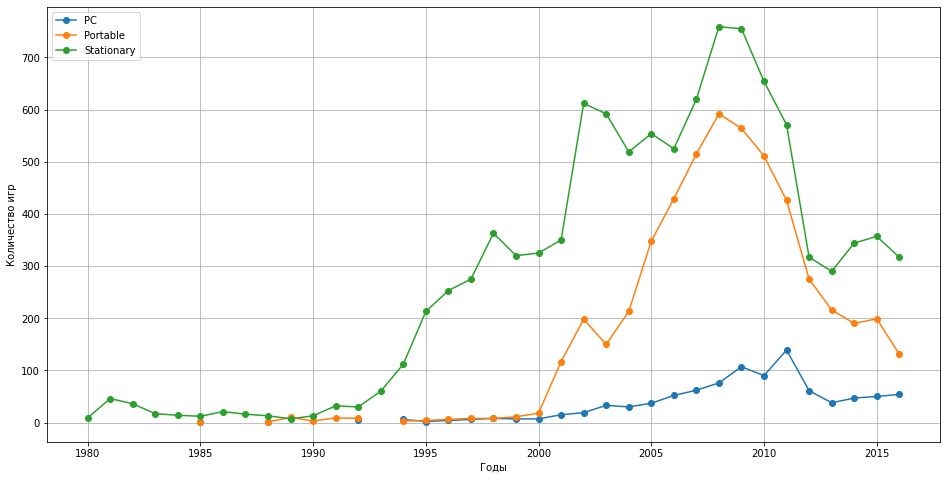

In [23]:
# количество релизов по годам
platform_type_releases = data.pivot_table(index='platform_type', values = 'name', columns='year_of_release', aggfunc='count').T

plt.figure(figsize=(16, 8))
plt.plot(platform_type_releases['PC'], marker ='o', label='PC')
plt.plot(platform_type_releases['portable'], marker ='o', label='Portable')
plt.plot(platform_type_releases['stationary'], marker ='o', label='Stationary')
plt.xlabel('Годы')
plt.ylabel('Количество игр')
plt.grid()
plt.legend(loc='upper left')
plt.show()

На графике видно, что довольно сильное развитие в 90х было у консольных видеоигр, в целом такую популярность можно объяснить, тем, что консоли были более доступными для приобретения пользователей. <br>
Рост продаж игр для ПК и портативных консолей начался лишь с 2000го года. К тому же видено отсутвие релизов в 93 году.

В целом можно считать данные до 94 года неактуальными, поэтому исключим их из анализа.

In [24]:
# новая таблица с данными от 94 года
data_cut = data[data['year_of_release'] >= 1994]

##### Найдем платформы с наибольшими количеством релизов.

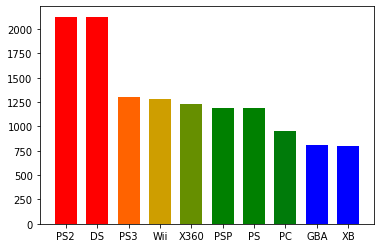

index,platform,All
14,PS2,2127
3,DS,2120
15,PS3,1306
24,Wii,1286
26,X360,1232
17,PSP,1193
13,PS,1190
11,PC,950
5,GBA,811
27,XB,803


In [25]:
platform_releases = data_cut.pivot_table(index='platform', values='total_sales', columns = 'year_of_release', 
                                      aggfunc = 'count', fill_value=0, margins=True).reset_index()
platform_releases = platform_releases[:-1]
platform_releases = platform_releases.rename_axis('index',  axis="columns")

# топ платформ по количеству выпущенных игр
platforms_top_releases = platform_releases.sort_values(by='All', ascending=False)[['platform', 'All']].head(10)

# гистограмма
fig, ax = plt.subplots()

clist = [(0, "red"), (0.125, "red"), (0.25, "orange"), (0.5, "green"), 
         (0.7, "green"), (0.75, "blue"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

N = 10
x = np.arange(N).astype(float)
y = np.random.uniform(0, 5, size=(N,))

ax.bar(platforms_top_releases['platform'], platforms_top_releases['All'], width = 0.7, color=rvb(x/N))
plt.show()
platforms_top_releases

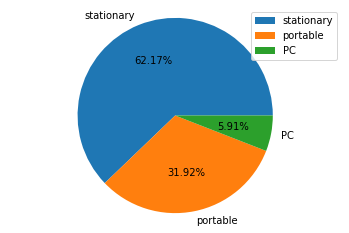

index,platform_type,All
2,stationary,9997
1,portable,5132
0,PC,950


In [26]:
# рассмотрим отдельно по типу платформы
platform_releases_type = data_cut.pivot_table(index='platform_type', values='total_sales', columns = 'year_of_release', 
                                      aggfunc = 'count', fill_value=0, margins=True).reset_index()
platform_releases_type = platform_releases_type[:-1]
platform_releases_type = platform_releases_type.rename_axis('index',  axis="columns")

# топ платформ по количеству выпущенных игр
platforms_top_releases_type = platform_releases_type.sort_values(by='All', ascending=False)[['platform_type', 'All']]

# круговая диаграмма
fig, ax = plt.subplots()
ax.pie(platforms_top_releases_type['All'], labels = platforms_top_releases_type['platform_type'], autopct='%.2f%%')
ax.axis("equal")
plt.legend(labels = platforms_top_releases_type['platform_type'] )
plt.show()
platforms_top_releases_type

По груговой диаграмме видим, что самым болшим количеством игр обладают консоли (самая популярная консоль PS2), на 2 месте портативные консоли и лишь на 3 месте игры для ПК.

##### Изучим платормы с наибольшей суммой продаж.

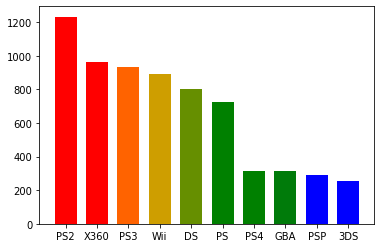

index,platform,All
14,PS2,1233.56
26,X360,961.24
15,PS3,931.34
24,Wii,891.18
3,DS,802.76
13,PS,727.58
16,PS4,314.14
5,GBA,312.88
17,PSP,289.53
1,3DS,257.81


In [27]:
platform_sales = data_cut.pivot_table(index='platform', values='total_sales', columns = 'year_of_release', 
                                      aggfunc = 'sum', fill_value=0, margins=True).reset_index()
platform_sales = platform_sales[:-1]
platform_sales = platform_sales.rename_axis('index',  axis="columns")

# топ платформ по количеству выпущенных игр
platform_top_sales = platform_sales.sort_values(by='All', ascending=False)[['platform', 'All']].head(10)

# гистограмма
fig, ax = plt.subplots()

clist = [(0, "red"), (0.125, "red"), (0.25, "orange"), (0.5, "green"), 
         (0.7, "green"), (0.75, "blue"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

N = 10
x = np.arange(N).astype(float)
y = np.random.uniform(0, 5, size=(N,))

ax.bar(platform_top_sales['platform'], platform_top_sales['All'], width = 0.7, color=rvb(x/N))
plt.show()
platform_top_sales

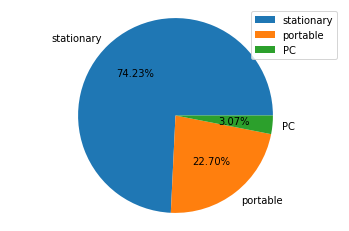

index,platform_type,All
2,stationary,6112.61
1,portable,1868.87
0,PC,252.66


In [28]:
# рассмотрим отдельно по типу платформы
platform_sales_type = data_cut.pivot_table(index='platform_type', values='total_sales', columns = 'year_of_release', 
                                      aggfunc = 'sum', fill_value=0, margins=True).reset_index()
platform_sales_type = platform_sales_type[:-1]
platform_sales_type = platform_sales_type.rename_axis('index',  axis="columns")

# топ платформ по количеству выпущенных игр
platform_top_sales_type = platform_sales_type.sort_values(by='All', ascending=False)[['platform_type', 'All']].head(10)

# круговая диаграмма
fig, ax = plt.subplots()
ax.pie(platform_top_sales_type['All'], labels = platform_top_sales_type['platform_type'],  autopct='%.2f%%')
ax.axis("equal")
plt.legend(labels = platform_top_sales_type['platform_type'] )
plt.show()
platform_top_sales_type

Опть же получаем, что наибольшую сумму продаж имеют консоли, а самой прибыльной является PS2.


#### Оценка продолжительности жизни платформ
Из списков топ платформ по сумме и количеству замечаем, что они почти совпадают, поэтому для отслеживания графиков этих топ платформ по годам, объединим их.

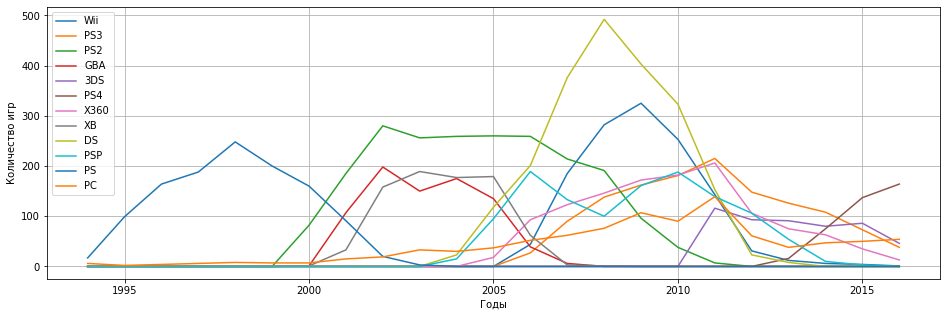

In [29]:
platforms_top_sales = list(platform_sales.sort_values(by='All', ascending=False)['platform'].head(10))
platforms_top_releases = list(platform_releases.sort_values(by='All', ascending=False)['platform'].head(10))
top_platforms = list(set(platforms_top_sales + platforms_top_releases))

# графики выходов игр на самых популярных платформах
plt.figure(figsize=(16, 5))
for i in top_platforms:
    plt.plot(platform_releases.loc[platform_releases['platform'] == i, list(platform_releases.columns[1:-1])].T, label=i)
plt.xlabel('Годы')
plt.ylabel('Количество игр')
plt.grid()
plt.legend(loc='upper left')
plt.show()

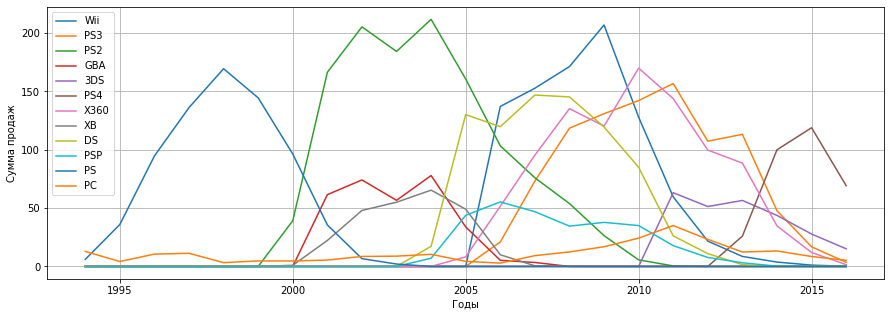

In [30]:
 # графики продаж игр на самых популярных платформах
plt.figure(figsize=(15, 5))
for i in top_platforms:
    plt.plot(platform_sales.loc[platform_sales['platform'] == i, list(platform_sales.columns[1:-1])].T, label=i)
plt.xlabel('Годы')
plt.ylabel('Сумма продаж')
plt.grid()
plt.legend(loc='upper left')
plt.show()

Оба графика имеют определенную схожу (этого стоило ожидать).

##### Срок жизни платформ

В целом уже по графику можно заметить годы "жизни" некоторых платформ: к примеру *PS* была популярная с 94 по 2003 год, с пиком в 1998 году.
Однако для лучшей оченки стоит создат таблицу с продолжительностью жизни платформы.

In [31]:
# создадим сводную таблицу
life = data_cut.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
# переименуем столбцы для простоты
life.set_axis(['platform', 'first_year', 'last_year'], axis='columns', inplace=True)
life['length'] = life.last_year - life.first_year + 1
print(life['length'].describe())
life.sort_values('length', ascending = False).head(10)

count    29.000000
mean      6.931034
std       4.876555
min       1.000000
25%       3.000000
50%       6.000000
75%      10.000000
max      23.000000
Name: length, dtype: float64


,platform,first_year,last_year,length
11,PC,1994,2016,23
14,PS2,2000,2011,12
17,PSP,2004,2015,12
26,X360,2005,2016,12
24,Wii,2006,2016,11
15,PS3,2006,2016,11
2,DC,1998,2008,11
3,DS,2004,2013,10
13,PS,1994,2003,10
27,XB,2000,2008,9


Из данных видно, что в среднем продолжительноть жизни одной платформы составляет около 6-7 лет (основной дапазон 3-10 лет). <br>
Самой "долгожительной" платформой является ПК. В целом ожидаемый резльтат с учетом развития технологий ПК и постепенным внедрением в повседневную жизнь.

Посмотрим значения для топа популярных платформ.

In [32]:
life.query('platform in @top_platforms')['length'].describe()

count    12.000000
mean     10.666667
std       4.618802
min       4.000000
25%       8.750000
50%      10.500000
75%      12.000000
max      23.000000
Name: length, dtype: float64

Для популярных платформ средний срок жизни - 11 лет, основной диапазон 9-12 лет.

##### Годы повлений новых платформ

Оценим годы появлений новых платформ

In [33]:
life_new = life.pivot_table(index = ['first_year'],values = ['platform'], aggfunc = ['count'])
life_new.sort_values('first_year')

,count
,platform
first_year,
1994,10
1995,1
1996,2
1998,1
1999,1
2000,3
2001,1
2004,2


По табличке видно, что в целом с 94 по 2013 года почти каждый код поялялись новые патформы. В основном по 1-2 в год, однако видно, что в 94 году произошел "бум" на платформы - их вышло аж 10 штук.

##### Оценка популярных в настоящее время платформ

Произведем оценку платформ, популярных именно в последние годы, ведь именно на них упор сейчас стоит делать разработчикам. 

Таким образом, нас точно не интересуют платформы, продаж и релизов для которых не было в последний год (наврядли после пустого года еще будут продажи), платформы старше 10, так как вероятно они скоро придут в упадок, и скорее всего в следующем году продажи для них будут крайне низкими.
Для оценки стоит взять платвормы возрастом не более 5 лет (за исключением ПК, ПК всегда популярно).

In [34]:
 # посмотрим на самые молодые платформы
life.query('last_year == 2016 and first_year > 2011')['platform']

16     PS4
25    WiiU
28    XOne
Name: platform, dtype: object

Можно сделать следующий вывод:
PlayStation 4, WiiU, XBox One находятся на подъеме. Для далнейшего анализа оставим толко эти платформы + ПК.

In [35]:
# сохраним список актуальных платформ
actual_platforms = ["PS4", "WiiU", "XOne", "PC"]
data_actual = data.query('year_of_release > 2011') 
data_actual.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,platform_type,company
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05,stationary,Sony
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27,stationary,Microsoft
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,RP,14.63,stationary,Sony
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,RP,14.60,portable,Nintendo
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79,stationary,Sony
35,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,13.68,stationary,Microsoft
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62,stationary,Sony
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,RP,11.68,portable,Nintendo
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24,stationary,Microsoft
62,New Super Mario Bros. 2,3DS,2012,Platform,3.66,3.14,2.47,0.63,78.0,7.2,E,9.90,portable,Nintendo


Построим диаграммы размаха

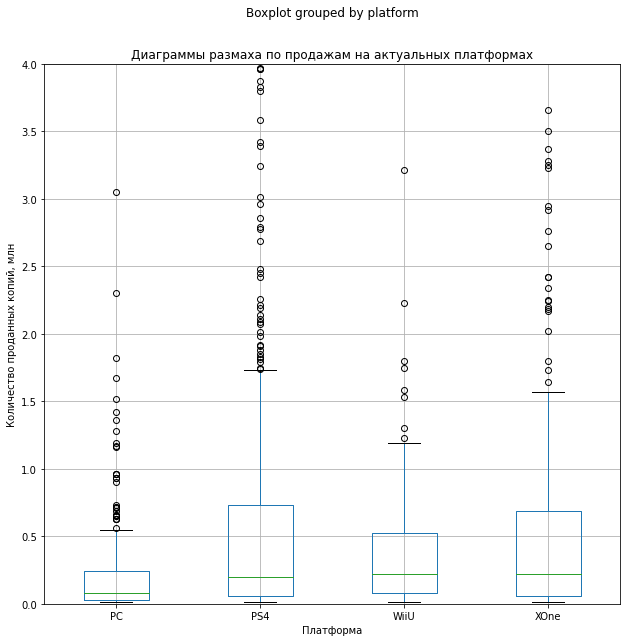

In [36]:
data_actual.query('platform in @actual_platforms')[['platform', 'name', 'total_sales']].boxplot(column='total_sales', 
                                                                                              by='platform', figsize=(10,10))
plt.xlabel('Платформа')
plt.ylabel('Количество проданных копий, млн')
plt.title('Диаграммы размаха по продажам на актуальных платформах')
plt.ylim(0, 4)
plt.show()

In [37]:
d_a = (data_actual.query('platform in @actual_platforms')
 .pivot_table(index='platform', values='total_sales',aggfunc=['sum', 'mean', 'median', 'std', 'count'])
 .sort_values(('median', 'total_sales'), ascending=False))
d_a.columns = ['sum', 'mean', 'median', 'std', 'count']
d_a.sort_values('mean', ascending = False)

,sum,mean,median,std,count
platform,,,,,
PS4,314.14,0.801378,0.20,1.609456,392
XOne,159.32,0.645020,0.22,1.036139,247
WiiU,82.19,0.559116,0.22,1.058836,147
PC,62.65,0.250600,0.08,0.494640,250


Лидером продаж является PlayStation 4, но и размах продаж по годам у нее самый большой. ПК является самой непопулярной платформой из вышепредставленных, но и самой стабильной - размах самый узкий. <br>
Выбросы у нас находятся только сверху - это хит-игры для каждой платформы. Видно, что у каждой из платформ случаются хиты, приносящие миллионы - доля таких успешных проектов выше всего у PlayStation 4 и XBox one - это видно и по большему среднему значению числа продаж.

#### Связь продаж и рассеивания внутри PS4

Посмотрим, как влияют оценки игры на ее продажи. Исследуем корреляцию.

In [38]:
data_ps4 = data_actual.query('platform == "PS4"')

print('Корреляция между оценкой критиков и продажами:', data_ps4.critic_score.corr(data_ps4.total_sales))
print('Корреляция между оценкой пользователей и продажами:', data_ps4.user_score.corr(data_ps4.total_sales))
print('Корреляция между оценками критиков и пользователей:', data_ps4.critic_score.corr(data_ps4.user_score))

Корреляция между оценкой критиков и продажами: 0.40656790206178095
Корреляция между оценкой пользователей и продажами: -0.031957110204556376
Корреляция между оценками критиков и пользователей: 0.5576539782764632


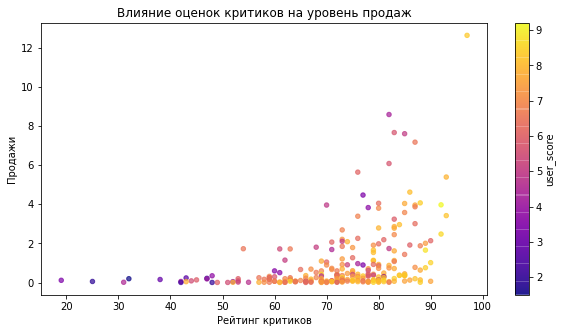

In [39]:
# построим график рассеяния 
data_ps4.plot.scatter('critic_score',  'total_sales', figsize=(10, 5), alpha=0.7, c='user_score', colormap='plasma', sharex=False)
plt.xlabel('Рейтинг критиков')
plt.ylabel('Продажи')
plt.title('Влияние оценок критиков на уровень продаж')
plt.show()

Корреляция между оценкой критиков и продажами есть есть (0.41), хоть и не большая, но все же четко видно, что сем выше рейтинг критиков, тем больше продаж.

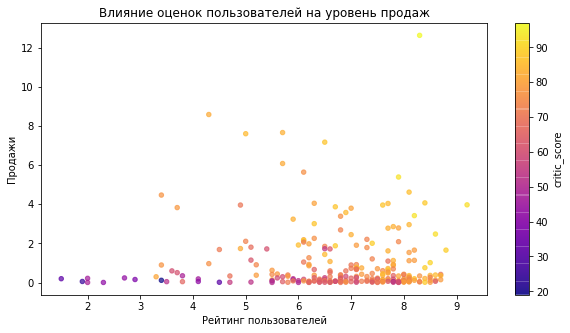

In [40]:
# построим график рассеяния 
data_ps4.plot.scatter('user_score', 'total_sales', figsize=(10, 5), alpha=0.7, c='critic_score', colormap='plasma', sharex=False)
plt.xlabel('Рейтинг пользователей')
plt.ylabel('Продажи')
plt.title('Влияние оценок пользователей на уровень продаж')
plt.show()

А вот между оценкой пользователей и уровнем продаж корреляции нет (-0.032).

В целом можно сказать, что при прогнозе продаж следуют опираться болше на рейтинг критиков.

#### Связь продаж и рассеивания на других топ платформах

Корреляция между оценкой критиков и продажами: 0.23724324311567915
Корреляция между оценкой пользователей и продажами: -0.12186747630735577
Корреляция между оценками критиков и пользователей: 0.4325873064924276


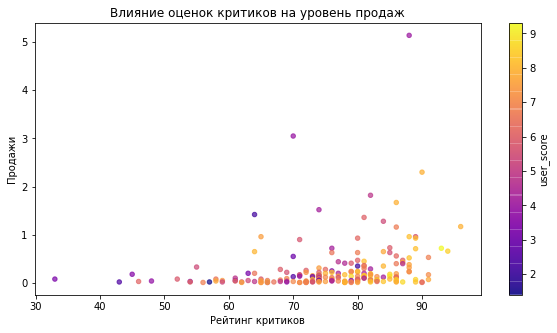

In [41]:
# PC
data_pc = data_actual.query('platform == "PC"')

print('Корреляция между оценкой критиков и продажами:', data_pc.critic_score.corr(data_pc.total_sales))
print('Корреляция между оценкой пользователей и продажами:', data_pc.user_score.corr(data_pc.total_sales))
print('Корреляция между оценками критиков и пользователей:', data_pc.critic_score.corr(data_pc.user_score))

# построим график рассеяния 
data_pc.plot.scatter('critic_score',  'total_sales', figsize=(10, 5), alpha=0.7, c='user_score', colormap='plasma', sharex=False)
plt.xlabel('Рейтинг критиков')
plt.ylabel('Продажи')
plt.title('Влияние оценок критиков на уровень продаж')
plt.show()

Корреляция между оценкой критиков и продажами: 0.4169983280084017
Корреляция между оценкой пользователей и продажами: -0.06892505328279414
Корреляция между оценками критиков и пользователей: 0.4724621124165801


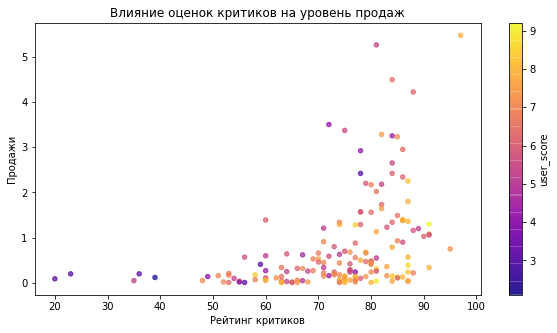

In [42]:
# XOne
data_xone = data_actual.query('platform == "XOne"')
print('Корреляция между оценкой критиков и продажами:', data_xone.critic_score.corr(data_xone.total_sales))
print('Корреляция между оценкой пользователей и продажами:', data_xone.user_score.corr(data_xone.total_sales))
print('Корреляция между оценками критиков и пользователей:', data_xone.critic_score.corr(data_xone.user_score))


# построим график рассеяния 
data_xone.plot.scatter('critic_score',  'total_sales', figsize=(10, 5), alpha=0.7, c='user_score', colormap='plasma', sharex=False)
plt.xlabel('Рейтинг критиков')
plt.ylabel('Продажи')
plt.title('Влияние оценок критиков на уровень продаж')
plt.show()

Корреляция между оценкой критиков и продажами: 0.34837976012017485
Корреляция между оценкой пользователей и продажами: 0.4002190202148617
Корреляция между оценками критиков и пользователей: 0.7700795968080212


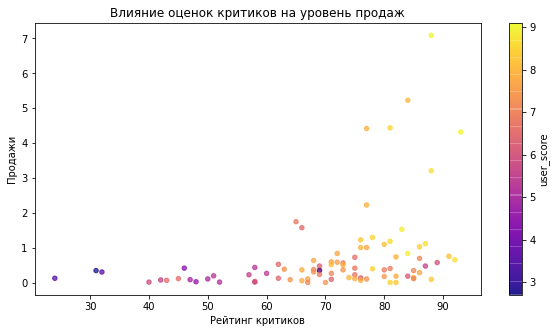

In [43]:
# data_wiiu
data_wiiu = data_actual.query('platform == "WiiU"')
print('Корреляция между оценкой критиков и продажами:', data_wiiu.critic_score.corr(data_wiiu.total_sales))
print('Корреляция между оценкой пользователей и продажами:', data_wiiu.user_score.corr(data_wiiu.total_sales))
print('Корреляция между оценками критиков и пользователей:', data_wiiu.critic_score.corr(data_wiiu.user_score))

# построим график рассеяния 
data_wiiu.plot.scatter('critic_score',  'total_sales', figsize=(10, 5), alpha=0.7, c='user_score', colormap='plasma', sharex=False)
plt.xlabel('Рейтинг критиков')
plt.ylabel('Продажи')
plt.title('Влияние оценок критиков на уровень продаж')
plt.show()

По таблицам и графикам заметно, хоть корреляции и не большие, но зависимость между оценками критиков и продажами имеется у всех платформ:
- WiiU - 0.35
- PC - 0.24
- XOne - 0.42 <br>
Корреляция с оценкой пользователей есть только у платформы *WiiU*(0.4) <br>
В целом, в оценке продаж лучше опираться на оценки критиков.

#### Общее распределение игр по жанрам

In [44]:
genre_sales = data_actual.pivot_table(index='genre', values='total_sales', columns = 'year_of_release', aggfunc = 'sum', fill_value=0, margins=True).reset_index()
genre_sales = genre_sales[:-1]
genre_sales = genre_sales.rename_axis(axis="columns").set_index('genre').sort_values(by='All', ascending=False)
genre_sales.head(10)

year_of_release,2012,2013,2014,2015,2016,All
genre,,,,,,
Action,119.25,122.51,97.23,72.02,30.11,441.12
Shooter,71.75,62.04,65.21,67.51,38.22,304.73
Role-Playing,46.91,44.45,45.62,37.64,18.18,192.80
Sports,30.42,41.17,45.15,40.84,23.49,181.07
Misc,22.22,25.27,23.38,11.57,2.60,85.04
Platform,18.37,24.54,8.81,6.05,3.23,61.00
Racing,13.61,12.37,16.66,8.07,2.79,53.50
Fighting,9.18,7.09,15.85,7.90,4.47,44.49
Simulation,13.36,8.63,5.58,5.66,1.89,35.12


Из таблицы видим, что самыми популярными жанрами являются экшен, шутеры, ролевые и спортивные игры. Остальные жанры значительно отстают по популярности.

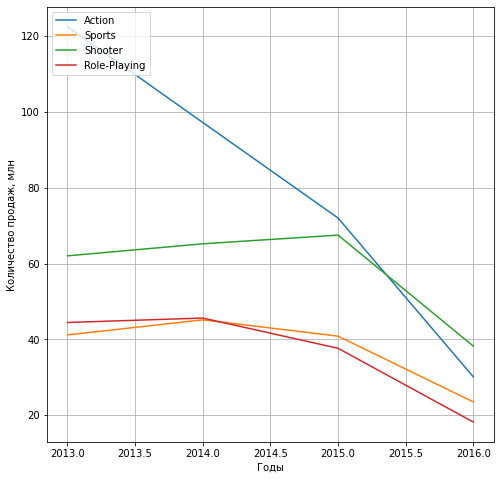

In [45]:
plt.figure(figsize=(8, 8))
for i in ['Action', 'Sports', 'Shooter', 'Role-Playing']:
    plt.plot(genre_sales.loc[i, list(genre_sales.columns[1:-1])].T, label=i)
plt.xlabel('Годы')
plt.ylabel('Количеcтво продаж, млн')
plt.grid()
plt.legend(loc='upper left')
plt.show()

Видим падение прадаж для всех жанров, однако по табличке такую картину мы наблюдаем абсолютно для всех жанров видеогр. <br>

Построим диаграммы размаха для жанров за последние 5 лет (все еще считаем, что актуальнейшие данные по платформам идут с 2011 года).

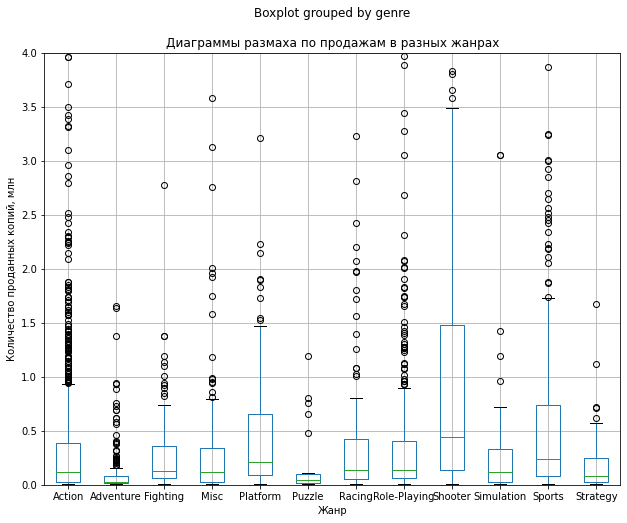

In [46]:
data_actual[['total_sales', 'genre']].boxplot(column='total_sales', by='genre', figsize=(10,8))
plt.xlabel('Жанр')
plt.ylabel('Количество проданных копий, млн')
plt.title('Диаграммы размаха по продажам в разных жанрах')
plt.ylim(0, 4)
plt.show()

In [47]:
data_genre = (data_actual
        .pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'mean', 'median', 'std', 'count'])
        .reset_index().sort_values(('median', 'total_sales'), ascending=False))
data_genre.columns = ['genre', 'sum', 'mean', 'median', 'std', 'count']
data_genre.sort_values('mean', ascending = False).head(10)

,genre,sum,mean,median,std,count
8,Shooter,304.73,1.296723,0.44,2.251662,235
4,Platform,61.00,0.717647,0.21,1.364413,85
10,Sports,181.07,0.675634,0.24,1.136378,268
7,Role-Playing,192.80,0.521081,0.14,1.315937,370
6,Racing,53.50,0.465217,0.14,0.888664,115
3,Misc,85.04,0.442917,0.12,1.081047,192
9,Simulation,35.12,0.439000,0.12,1.244500,80
0,Action,441.12,0.427856,0.12,1.166504,1031
2,Fighting,44.49,0.408165,0.13,0.910385,109
11,Strategy,13.34,0.187887,0.08,0.271976,71


По диаграмме размаха видно, что хит игр очень много у жанров экшен, ролевые и спортивные игры. Однако по среднему уровню продаж топ жанрами являются: шутеры, платформеры, спортивные, ролевые игры и гонки. <br>

**Вывод этапа**:
- Началом расцевта игровой индустрии можно считать 1994 год. Именно с него индустрия начала развиваться быстрыми темпами (данные до этого года можно считать неактуальными).
- Были выяснены самые популярные платформы. Топ-платформами в основном являются *консоли* с самой популярной `PS2` во главе, котрая занимает первое место по количеству игр и сумме их продаж, затем идут *портативные консоли* и только потом *ПК*. 
- Был проведен анализ долгожительности платформ. В среднем "жизнь" платформы составляет порядка 3-10 лет, в случае если платформа популяона, то 9-12 лет. На *ПК* же годы не влияют, держится 24 года на плаву и уходить не собирается. Новые платформы появлялись с 1994 по 2013 практически каждый год по 1-2 штуки. Однако в 94 году был заметен бум на платформы - их появилось целых 10 штук.
- Проведен анализ новейших популярных платформ. Самими молодыми платформами оказались `PS4`, `WiiU`, `Xbox One`. `PS4` - является лидером продаж.
- Проведенные анализ зависимости продаж от оценки пользователей и критиков показал, что оценка пользователей никак не влияет на продажи. Корреляция: `PS4` - -0.03, `Xbox One` - -0.07, `PC` - -0.12, `WiiU` - 0.40 (единственное исключение). А вот оценка критиков влияет на продажи на прямую. Корреляция: `PS4` - 0.40, `Xbox One` - 0.42, `PC` - 0.24, `WiiU` - 0.35. Поэтому при прогнозах стоит ориентироваться именно на оценку от критиков.
- Анализ жанров показал, что самыми популярными жанрамя являются *экшен*, *шутеры*, *ролевые* и *спортивные игры*, коорые также являются и самыми большими по количеству топ-игр. Однако самыми продаваемыми по средним данным жанрами оказались *шутеры*, *платформеры*, *спортивные*, *ролевые игры*, а также *гонки*.
- Заметен спад продаж

### Портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):
 - Самые популярные платформы (топ-5)
 - Самые популярные жанры (топ-5)
 - Влияет ли рейтинг ESRB на продажи в отдельном регионе

Проверим регион Северной Америки.

In [48]:
# топ платформ
top_platform = (data_actual.pivot_table(index='platform', values='na_sales', aggfunc='sum')
                .sort_values('na_sales', ascending=False).head())
top_platform

,na_sales
platform,
X360,140.05
PS4,108.74
PS3,103.38
XOne,93.12
3DS,55.31


In [49]:
# топ жанров
top_genres = (data_actual.pivot_table(index='genre', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales', ascending=False).head())
top_genres

,na_sales
genre,
Action,177.84
Shooter,144.77
Sports,81.53
Role-Playing,64.00
Misc,38.19


Видно, что в Северной Америке популярностью пользуются именно консоли, причем самой популярной консолью за все годы оказалась `Xbox 360`. Остальные консоли в топе не сильно отстают по продажам. <br>
Самым полярным жанром является *экшен*. Удивительно, но в топ попал смешанный жанр игр *Misc*, который раньше не попадал в топы при исследовании.

Проверим регион Европы.

In [50]:
# топ платформ
top_platform = (data_actual.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
                .sort_values('eu_sales', ascending=False).head())
top_platform

,eu_sales
platform,
PS4,141.09
PS3,106.86
X360,74.52
XOne,51.59
3DS,42.64


In [51]:
# топ жанров
top_genres = (data_actual.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales', ascending=False).head())
top_genres

,eu_sales
genre,
Action,159.34
Shooter,113.47
Sports,69.09
Role-Playing,48.53
Racing,27.29


В Европе же самой популярной консолью является `PS4`, а вот `Xbox 360` занимает 3е место. Хоть в Европе также популярны консоли, однако топ консолей уже совершенно другой. <br>
Топ же жанров совпадает с также самым популярным - *экшеном*.

Проверим регион Японии.

In [52]:
# топ платформ
top_platform = (data_actual.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
                .sort_values('jp_sales', ascending=False).head())
top_platform

,jp_sales
platform,
3DS,87.79
PS3,35.29
PSV,21.04
PS4,15.96
WiiU,13.01


In [53]:
# топ жанров
top_genres = (data_actual.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales', ascending=False).head())
top_genres

,jp_sales
genre,
Role-Playing,65.44
Action,52.80
Misc,12.86
Simulation,10.41
Fighting,9.44


В Японии популярностью пользуются уже не только обычные консоли, но и портативные консоли. Верхушку топа занимает `3DS`. <br>
Самым же популярным жанром является *role-playing*. Также в Японии популярен жанры *файтингов* и *симуляторов*. <br>
Такое различие в предпочитаемых жанрах вероятно можно объяснить культурной разницей стран: Европа и Северная Америка довольно близки в культурном и жизненом понимании, когда Японии более обособлена от них.

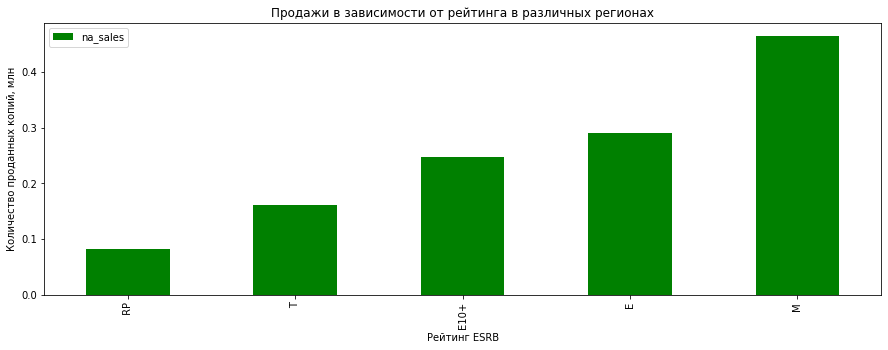

In [54]:
# график Севреной Америки
(data_actual.pivot_table(index='rating', values='na_sales', aggfunc='mean')
    .sort_values(by='na_sales')
    .plot(kind='bar', figsize=(15, 5), color='g'))
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Количество проданных копий, млн')
plt.title('Продажи в зависимости от рейтинга в различных регионах')
plt.show()

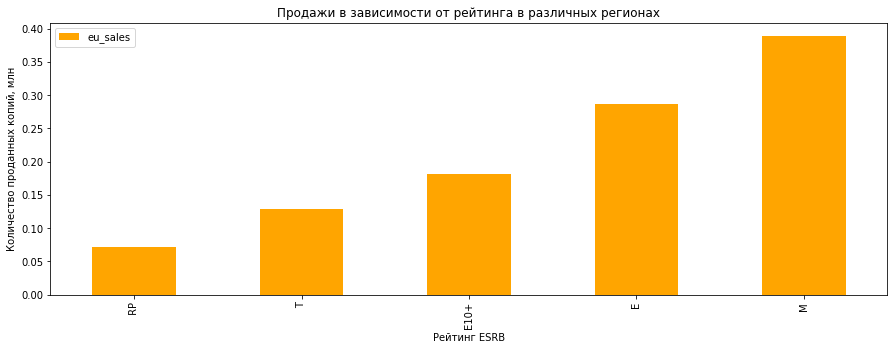

In [55]:
# график Европы
(data_actual.pivot_table(index='rating', values='eu_sales', aggfunc='mean')
    .sort_values(by='eu_sales')
    .plot(kind='bar', figsize=(15, 5), color='orange'))
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Количество проданных копий, млн')
plt.title('Продажи в зависимости от рейтинга в различных регионах')
plt.show()

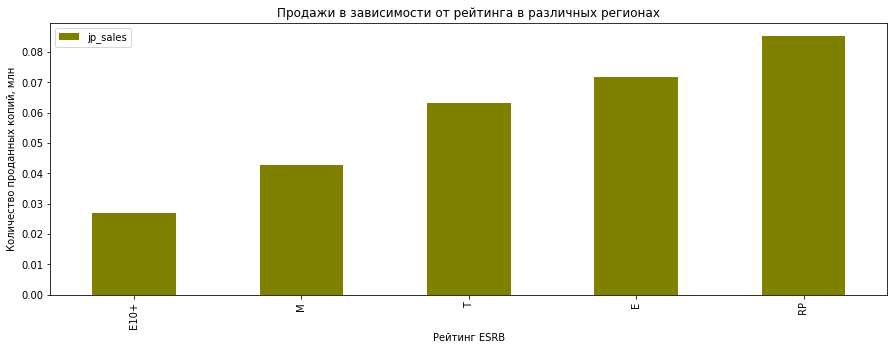

In [56]:
# график Японии
(data_actual.pivot_table(index='rating', values='jp_sales', aggfunc='mean')
    .sort_values(by='jp_sales')
    .plot(kind='bar', figsize=(15, 5), color='olive'))
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Количество проданных копий, млн')
plt.title('Продажи в зависимости от рейтинга в различных регионах')
plt.show()

Entertainment Software Rating Board (ESRB) — негосударственная организация, основное направление деятельности которой принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде. <br>
В Японии популярны игры без четкого рейтинга (мы меняли пропущеный рейтинг на *RP*), верояно это именно потому что японские игры в основном не проходят проверку на рейтинг, а проходят именно те, которые планируются для международного релиза. <br>
В целом можно сказать, что чем выше возрастное ограничение игры, тем она популярней.

**Вывод этапа**:
- Анализ популярности платформ показал, что самыми популярными платформами везде являются именно консоли, хотя во всех регионах этот топ отличется. 
- В Северной Америке самой популярной консолью является `X360`, в Европе - `PS4`, в Японии - `3DS`.
- Популярные жанры схожи для Европы и Америки, где самый популярный жанр - это *экшен*. Тогда как в Японии популярен *роулплей*, *симуляторы* и *файтинги*, и совсем непопулярны *шутеры*.
- Выявлено, что многие игры из Японии не проходят проверку ESRB
- В целом видна закономерность между популярностью игр и увеличением возрастного ограничения.

### Проверка гипотез


#### Гипотеза 1.

Проверим гипотезу "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые". <br>
Для проверки этой гипотезы потребуется тест двух генеральных совокупностей по взятым из них выборкам(stats.ttest_ind). У такого теста нулевая гипотеза должна быть о равенстве, альтернативная о различии.

**Н0**: "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые". <br>
**H1**: "Средние пользовательские рейтинги платформ Xbox One и PC разные"

Значение критического уровня вероятности (альфа) примем равным 5%.

In [57]:
alpha = 0.05  # критический уровень статистической значимости
results = st.ttest_ind(
    data_actual[(data_actual.platform == "XOne") & (data_actual.user_score.notna())]['user_score'], 
    data_actual[(data_actual.platform == "PC") & (data_actual.user_score.notna())]['user_score']
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


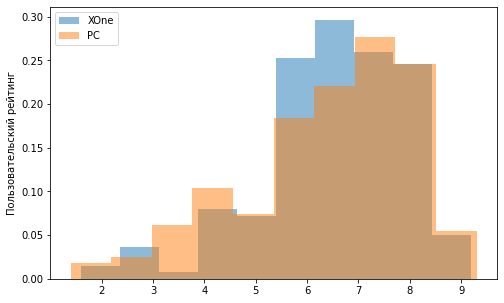

In [58]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(data_actual[(data_actual.platform == "XOne") & (data_actual.user_score.notna())]['user_score'], 
        bins=10, density=True, alpha=0.5, label = 'XOne')
ax.hist(data_actual[(data_actual.platform == "PC") & (data_actual.user_score.notna())]['user_score'], 
        bins=10, density=True, alpha=0.5, label = 'PC')
plt.ylabel('Пользовательский рейтинг')
plt.legend(loc='upper left')
plt.show()

И проверка гиптезы и график наглядно показывают, что первоначальная проверяемая гипотеза подтверждается.

#### Гипотеза 2.

Проверим гипотезу "Средние пользовательские рейтинги жанров Action и Sports разные.". <br>
Для проверки этой гипотезы потребуется тест двух генеральных совокупностей по взятым из них выборкам(stats.ttest_ind). У такого теста нулевая гипотеза должна быть о равенстве, альтернативная о различии.

**Н0**: "Средние пользовательские рейтинги жанров Action и Sports одинаковые". <br>
**H1**: "Средние пользовательские рейтинги жанров Action и Sports разные"

Значение критического уровня вероятности (альфа) примем равным 5%.

In [59]:
alpha = 0.05  # критический уровень статистической значимости
results = st.ttest_ind(
    data_actual[(data_actual.genre == "Action") & (data_actual.user_score.notna())]['user_score'], 
    data_actual[(data_actual.genre == "Sports") & (data_actual.user_score.notna())]['user_score']
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


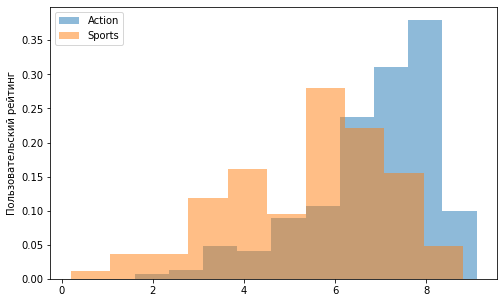

In [60]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(data_actual[(data_actual.genre == "Action") & (data_actual.user_score.notna())]['user_score'], 
        bins=10, density=True, alpha=0.5, label = 'Action')
ax.hist(data_actual[(data_actual.genre == "Sports") & (data_actual.user_score.notna())]['user_score'], 
        bins=10, density=True, alpha=0.5, label = 'Sports')
plt.ylabel('Пользовательский рейтинг')
plt.legend(loc='upper left')
plt.show()

По графику видно, что пользовательские рейтинги разные, и проверка гипотезы показала подтверждение первоначальной гипотезы.

**Вывод этапа**: Были проверены гипотезы:
- Гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Гипотеза подтверждена со знаением p-value 0.55.
- Гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports разные. Гипотеза подтверждена со значением p-value 3.72.

### Общий вывод:<br>

Итак, полученный архив данных - данные о продажах видеоигр.

На этапе предобработки данных была проведена проверка данных на начличие пропущенных значений, которые были обнаружены в столбцах `name` (такие строки удалены), `genre` (такие строки удалены), `year_of_release` (такие строки удалены), `rating` (пропуски заменены на значение *RP*), `critic_score` (оставлено без изменений),	`user_score`(оставлено без изменений). Обработаны неявные и явные дубликаты. Была исправлена ошибка с неверным форматом данных: столбец с годом выпуска приведен к типу *int*, `user_score` к типу *float*. Названия столбцов приведены к snake_case.
Для дальнейшего анализа добавлен новый столбец с сумарной продажей во всех регионах `total_sales`.

На этапе анализа были исследованы и выявлены следующие пункты:
- Началом расцевта игровой индустрии можно считать 1994 год. Именно с него индустрия начала развиваться быстрыми темпами (данные до этого года можно считать неактуальными).
- Были выяснены самые популярные платформы. Топ-платформами в основном являются *консоли* с самой популярной `PS2` во главе, котрая занимает первое место по количеству игр и сумме их продаж, затем идут *портативные консоли* и только потом *ПК*. 
- Был проведен анализ долгожительности платформ. В среднем "жизнь" платформы составляет порядка 3-10 лет, в случае если платформа популяона, то 9-12 лет. На *ПК* же годы не влияют, держится 24 года на плаву и уходить не собирается. Новые платформы появлялись с 1994 по 2013 практически каждый год по 1-2 штуки. Однако в 94 году был заметен бум на платформы - их появилось целых 10 штук.
- Проведен анализ новейших популярных платформ. Самими молодыми платформами оказались `PS4`, `WiiU`, `Xbox One`. `PS4` - является лидером продаж.
- Проведенные анализ зависимости продаж от оценки пользователей и критиков показал, что оценка пользователей никак не влияет на продажи. Корреляция: `PS4` - -0.03, `Xbox One` - -0.07, `PC` - -0.12, `WiiU` - 0.40 (единственное исключение). А вот оценка критиков влияет на продажи на прямую. Корреляция: `PS4` - 0.40, `Xbox One` - 0.42, `PC` - 0.24, `WiiU` - 0.35. Поэтому при прогнозах стоит ориентироваться именно на оценку от критиков.
- Анализ жанров показал, что самыми популярными жанрамя являются *экшен*, *шутеры*, *ролевые* и *спортивные игры*, коорые также являются и самыми большими по количеству топ-игр. Однако самыми продаваемыми по средним данным жанрами оказались *шутеры*, *платформеры*, *спортивные*, *ролевые игры*, а также *гонки*.
- Заметен спад продаж

Исследование портрета пользователя каждого региона дало понять, что самыми популярными платформами везде являются именно консоли, хотя во всех регионах этот топ отличется. В Северной Америке самой популярной консолью является `X360`, в Европе - `PS4`, в Японии - `3DS`. Популярные жанры схожи для Европы и Америки, где самый популярный жанр - это *экшен*. Тогда как в Японии популярены *роулплей*, *симуляторы* и *файтинги*, и совсем непопулярны *шутеры*, что может получаться из-за культурных особенностей.<br>
Анализ показал, что многие игры из Японии не проходят проверку ESRB, так как этот рейтинг изначально существует для игр именно из США и Канады, однако у части игр этот рейтинг всеже есть, вероятно потому что эти игры планировались для релиза и в Северной Америке. В целом можно сказать, что чем выше возрастное ограничение игры, тем она популярней.

Были проверены гипотезы:
- Гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Гипотеза подтверждена со знаением p-value 0.55.
- Гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports разные. Гипотеза подтверждена со значением p-value 3.72.
Для их проверки использовался тест двух генеральных совокупностей по взятым из них выборкам(stats.ttest_ind).